Author: [Ahmed Sobhi](ahmedyousrisobhi@gmail.com)

Creation_data: 23th Jul 2023

Objective: Data Cleaning

## Importing Libararies and Packages

In [11]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from tqdm import tqdm

from dataprep.eda import create_report

## Required Functions Definision

In [12]:
# Function to handle outliers
def remove_outlier_iqr(_df:pd.DataFrame, features_lst:list, target_col:str)->pd.DataFrame:
    """
        Used to remove outliers based on input selected features in the dataframe.
        Outlier removal method is IQR

        PARAMETERS
            df: pandas DataFrame, describe input dataframe which require outliers removal
            features_lst: list, describe the input columns features list.
            target_col: str, describe the target column which we need to remove outlier from.

        RETURN
            Pandas DataFrame, after removing outliers
    """

    # Make a copy of input dataframe
    df_copy = _df.copy()

    # Create empty list for records storing, to be converted into dataframe later.
    Q1 = df_copy.groupby(features_lst)[target_col].transform('quantile', 0.25)
    Q3 = df_copy.groupby(features_lst)[target_col].transform('quantile', 0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR

    upper_bound = Q3 + 1.5 * IQR

    return df_copy[df_copy[target_col].between(lower_bound, upper_bound, inclusive='both')]


def remove_outlier(df:pd.DataFrame, neglected_cols:list, dependant_cols:list)->pd.DataFrame:
    """
        Used to extract numerical columns and drop used input neglected columns,
        Then remove outliers from these columns based on selected dependant features
        using IQR

        PARAMETERS
            df: pandas DataFrame, user input dataframe.
            neglected_cols: list, numerical columns to drop and not interested in removing outliers for.
            dependant_cols: lst, columns to remove ouliters based on them.

        RETURN
            pandas DataFrame after removing outliers.    
    """

    # Create a copy of input dataset
    df_copy = df.copy()

    # Select numerical columns
    numeric_cols = df_copy.select_dtypes('number').columns.tolist()

    # Remove neglected columns
    for col in neglected_cols:
        if col in numeric_cols:
            numeric_cols.remove(col)    

    # Iterate over each numerical col and remove ouliers
    for col in tqdm(numeric_cols, total=len(numeric_cols)):

        # Using Iqr to remove outliers
        df_copy = remove_outlier_iqr(df_copy, dependant_cols, col)

    # It is a nesessary step to reset_index
    df_copy.reset_index(drop=True, inplace=True)

    return df_copy


# Function for Plotting
def plot_numeric_features(df:pd.DataFrame, cols_to_drop:list, plot_type, save_plot:bool, plot_name:str) -> None:
    """
        Used to plot numerical featuers based on input selected plot.

        Input:
            df: pandas DataFrame, input dataframe.
            cols_to_drop: list, list of columns to drop.
            plot_type: function, define the plot type.
            save_plot: boolean, to whether save plot or not.
            plot_name: str, name of the figure.

        Output:
            None
    """

    # Select Numerical columns only
    features_numeric = (
        df.drop(cols_to_drop, axis=1)
        .select_dtypes('number')
        .columns.tolist()
    )

    # Calculate the number of rows and columns for subplots
    num_rows = int(len(features_numeric) / 2) + len(features_numeric) % 2
    num_cols = 2

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

    # Iterate over features and plot distplot on subplots
    for i, feature in enumerate(features_numeric):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        plot_type(df[feature], ax=ax)
        ax.set_title(f'{plot_type.__name__} of {feature.capitalize()}')

    # Remove empty subplots if necessary
    if len(features_numeric) % 2 != 0:
        fig.delaxes(axes[num_rows - 1, num_cols - 1])

    # Set title for the whole plot
    fig.suptitle(f'{plot_type.__name__} Analysis', fontsize=16)
    plt.tight_layout()

    # Save the plot
    if save_plot == True:
        try:
            plt.savefig(f'../report/plots/{plot_name}_{plot_type.__name__}.jpg')
        except FileNotFoundError:
            print('Wring file or file path')
            print('Creating new directory')
            # Create required directories
            if not os.path.exists('../report/plots'):
                os.makedirs('../report/plots/')
            plt.savefig(f'../report/plots/{plot_name}_{plot_type.__name__}.jpg')
        
    plt.show()

## Loading Dataset

In [13]:
df = (
    pd.read_csv('../data/raw/full_gen_data.csv')
    .assign(
        retailweek = lambda x: pd.to_datetime(x.retailweek),
        customer_id = lambda x: x.customer_id.astype('int')
    )
    .rename(columns={
        'article':'article_id_1',
        'article.1':"article_id_2",
        'promo1':'promo_media_ads',
        'promo2':'promo_store_event',
        'cost':'cost_article_2'
    })
)

# Sorting by [Country, customer_id, retailweek]
df = df.sort_values(by=['country', 'customer_id', 'retailweek'])

df.head()

,country,article_id_1,sales,regular_price,current_price,ratio,retailweek,promo_media_ads,promo_store_event,customer_id,...,style,sizes,gender,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col,label
14560,Austria,LG5858,234,39.95,11.95,0.299124,2015-04-12,0,0,4001,...,slim,"xxs,xs,s,m,l,xl,xxl",women,205,104,57,255,187,255,0
14561,Austria,LG5858,234,39.95,11.95,0.299124,2015-04-12,0,0,4001,...,regular,"xxs,xs,s,m,l,xl,xxl",women,188,238,104,255,187,255,0
14562,Austria,LG5858,234,39.95,11.95,0.299124,2015-04-12,0,0,4001,...,regular,"xxs,xs,s,m,l,xl,xxl",women,205,173,0,255,187,255,0
14563,Austria,LG5858,234,39.95,11.95,0.299124,2015-04-12,0,0,4001,...,regular,"xxs,xs,s,m,l,xl,xxl",kids,205,140,149,164,211,238,0
14564,Austria,LG5858,234,39.95,11.95,0.299124,2015-04-12,0,0,4001,...,regular,"xxs,xs,s,m,l,xl,xxl",women,138,43,226,164,211,238,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 14560 to 3799
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   country            100000 non-null  object        
 1   article_id_1       100000 non-null  object        
 2   sales              100000 non-null  int64         
 3   regular_price      100000 non-null  float64       
 4   current_price      100000 non-null  float64       
 5   ratio              100000 non-null  float64       
 6   retailweek         100000 non-null  datetime64[ns]
 7   promo_media_ads    100000 non-null  int64         
 8   promo_store_event  100000 non-null  int64         
 9   customer_id        100000 non-null  int64         
 10  article_id_2       100000 non-null  object        
 11  productgroup       100000 non-null  object        
 12  category           100000 non-null  object        
 13  cost_article_2     100000 non-null  float6

## Handling Outliers

In [15]:
numerical_cols_to_neglect = ['article_id_1', 'article_id_2', 'customer_id', 
        'rgb_r_main_col', 'rgb_g_main_col', 'rgb_b_main_col', 
        'rgb_r_sec_col', 'rgb_g_sec_col', 'rgb_b_sec_col',
        'promo_media_ads', 'promo_store_event', 'label']

df = remove_outlier(
    df, 
    numerical_cols_to_neglect,
    ['article_id_2', 'category']
    )

100%|██████████| 5/5 [00:00<00:00, 27.45it/s]


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sales,86520.0,34.742834,33.510501,1.000000,9.000000,23.000000,50.000000,145.00
regular_price,86520.0,49.072284,31.963125,3.950000,25.950000,39.950000,69.950000,153.95
current_price,86520.0,25.854762,18.110931,1.950000,11.950000,20.950000,35.950000,78.95
ratio,86520.0,0.546703,0.190875,0.296482,0.364575,0.528719,0.697322,1.00
promo_media_ads,86520.0,0.053514,0.225057,0.000000,0.000000,0.000000,0.000000,1.00
promo_store_event,86520.0,0.004623,0.067837,0.000000,0.000000,0.000000,0.000000,1.00
customer_id,86520.0,2707.640661,1913.520759,1.000000,1008.750000,1994.500000,4569.250000,5999.00
cost_article_2,86520.0,6.517000,3.914731,1.290000,2.290000,6.950000,9.600000,13.29
rgb_r_main_col,86520.0,161.400000,39.790178,79.000000,138.000000,160.000000,205.000000,205.00
rgb_g_main_col,86520.0,139.600000,63.641864,26.000000,104.000000,144.000000,181.000000,238.00


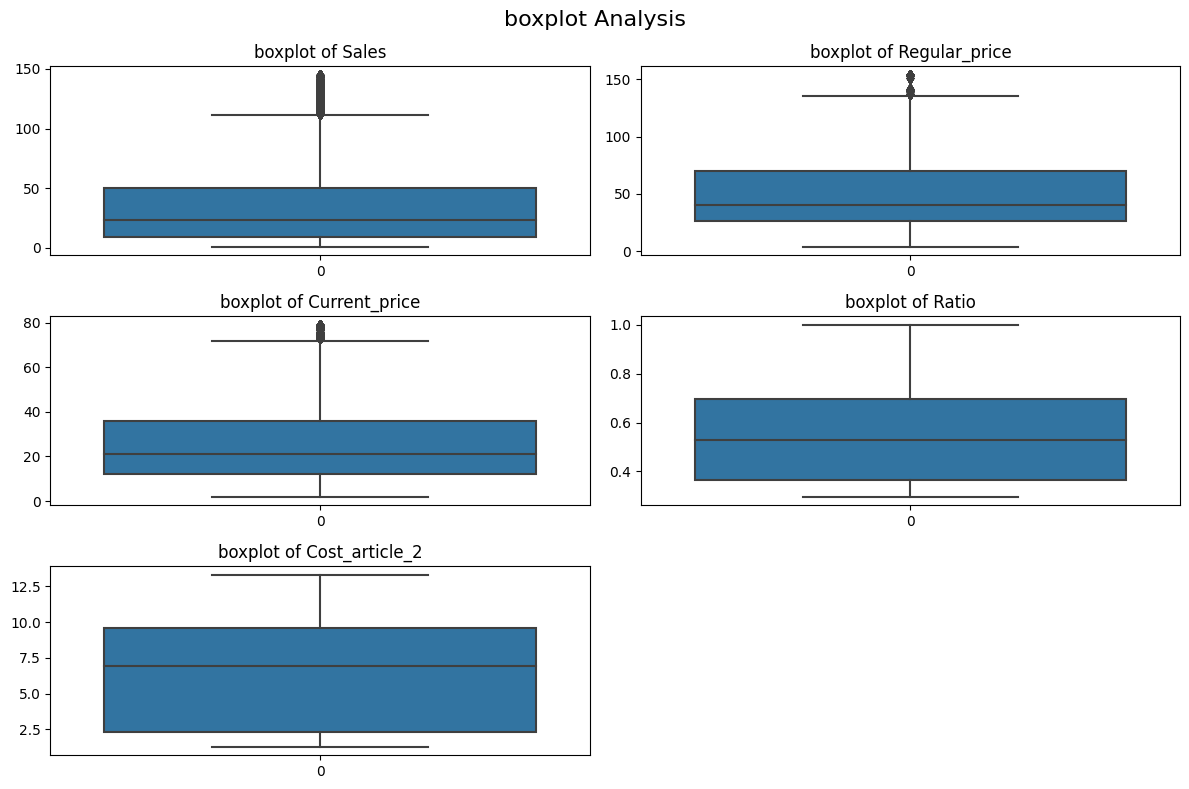

In [17]:
plot_numeric_features(
    df, 
    numerical_cols_to_neglect, 
    sns.boxplot, 
    True, 
    'Numeric Data After cleaning outliers'
    )

## Handling MisLabeling Data

In [18]:
# Customers who bought due to advertising effect even without promos being applied.
df_label1_without_promos = df[(df.promo_media_ads==0)&(df.promo_store_event==0)&(df.label == 1)]

df_label1_without_promos.shape[0]*100/df.shape[0]

12.572815533980583

There are contradictions in the label values, where customers are labels to being purchase due to promo but actaully there were no promo available during this time.

Due to not fully understanding the domain in this project, to handle this miss labeling, they will be left as they are.

# Generate a report for modified data

In [19]:
# Create a report for raw dataset
report = create_report(df)

# Save report locally
report.save('../report/reports/data_cleaned_report')

  0%|          | 0/2942 [00:00<?, ?it/s]

/home/yousri/anaconda3/envs/fixedsolution/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/yousri/anaconda3/envs/fixedsolution/lib/python3.9/site-packages/dataprep/eda/distribution/render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))


Report has been saved to ../report/reports/data_cleaned_report.html!


In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sales,86520.0,34.742834,33.510501,1.000000,9.000000,23.000000,50.000000,145.00
regular_price,86520.0,49.072284,31.963125,3.950000,25.950000,39.950000,69.950000,153.95
current_price,86520.0,25.854762,18.110931,1.950000,11.950000,20.950000,35.950000,78.95
ratio,86520.0,0.546703,0.190875,0.296482,0.364575,0.528719,0.697322,1.00
promo_media_ads,86520.0,0.053514,0.225057,0.000000,0.000000,0.000000,0.000000,1.00
promo_store_event,86520.0,0.004623,0.067837,0.000000,0.000000,0.000000,0.000000,1.00
customer_id,86520.0,2707.640661,1913.520759,1.000000,1008.750000,1994.500000,4569.250000,5999.00
cost_article_2,86520.0,6.517000,3.914731,1.290000,2.290000,6.950000,9.600000,13.29
rgb_r_main_col,86520.0,161.400000,39.790178,79.000000,138.000000,160.000000,205.000000,205.00
rgb_g_main_col,86520.0,139.600000,63.641864,26.000000,104.000000,144.000000,181.000000,238.00


# Save data locally

In [20]:
df.to_csv('../data/intermid/full_gen_data.csv', index=False)